In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [2]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'beans',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1034 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/0.1.0.incompleteH5BLUD/beans-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/133 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/0.1.0.incompleteH5BLUD/beans-validation.tfrecord*...:   0%|         …

Generating test examples...:   0%|          | 0/128 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/0.1.0.incompleteH5BLUD/beans-test.tfrecord*...:   0%|          | 0/1…

Dataset beans downloaded and prepared to /root/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.


In [3]:
NumOfClasses = metadata.features['label'].num_classes
print(NumOfClasses)

3




Implementing the data augmentation layers. Drawing an exemplary image and its several augmented versions.

In [4]:
DataAugmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

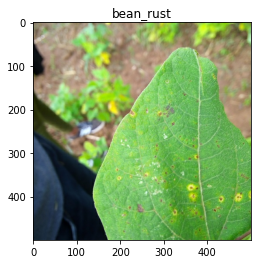

In [6]:
GetLabelName = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(GetLabelName(label))

In [7]:
for i, example in enumerate(train_ds.take(5)):
    print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (500, 500, 3) label: 1
Image 2 shape: (500, 500, 3) label: 1
Image 3 shape: (500, 500, 3) label: 0
Image 4 shape: (500, 500, 3) label: 0
Image 5 shape: (500, 500, 3) label: 1


In [8]:
# Add the image to a batch.
image = tf.expand_dims(image, 0)
print(type(image))
print(np.shape(image))


(1, 500, 500, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>


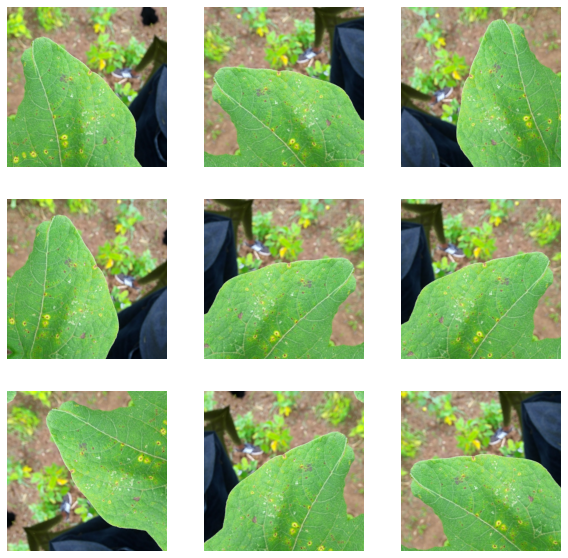

In [9]:
plt.figure(figsize=(10, 10))
for i in range(9):
  AgmentedImage = DataAugmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(AgmentedImage[0]/255)
  plt.axis("off")



CNN architecture on dataset. Keeping the values of loss and accuracy in a history object.

In [10]:
BATCH_SIZE = 32

IMG_SIZE = 500

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])
print(tf.data.AUTOTUNE)

-1


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)
  
  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(BATCH_SIZE)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (DataAugmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)
  
  # Use buffered prefetching on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

In [12]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

In [13]:
val_batches = tf.data.experimental.cardinality(val_ds)
print(val_batches)

tf.Tensor(4, shape=(), dtype=int64)


In [34]:
model_cnn = tf.keras.models.Sequential()
model_cnn.add(tf.keras.layers.RandomFlip('horizontal'))
model_cnn.add(tf.keras.layers.RandomRotation(0.2))
model_cnn.add(tf.keras.layers.experimental.preprocessing.Resizing(125,125))
model_cnn.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu', input_shape=(32, 32, 3)))
model_cnn.add(tf.keras.layers.MaxPool2D())
model_cnn.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu', input_shape=(32, 32, 3)))
model_cnn.add(tf.keras.layers.MaxPool2D())
model_cnn.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu', input_shape=(32, 32, 3)))
model_cnn.add(tf.keras.layers.MaxPool2D())
model_cnn.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu', input_shape=(32, 32, 3)))
model_cnn.add(tf.keras.layers.MaxPool2D())
model_cnn.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu', input_shape=(32, 32, 3)))
model_cnn.add(tf.keras.layers.MaxPool2D())
model_cnn.add(tf.keras.layers.Flatten())
model_cnn.add(tf.keras.layers.Dense(256, activation='relu'))
model_cnn.add(tf.keras.layers.Dense(128, activation='relu'))
model_cnn.add(tf.keras.layers.Dense(3, activation='softmax'))

In [78]:
model_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_2 (RandomFlip)  (None, 500, 500, 3)       0         
                                                                 
 random_rotation_2 (RandomRo  (None, 500, 500, 3)      0         
 tation)                                                         
                                                                 
 resizing_2 (Resizing)       (None, 125, 125, 3)       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 125, 125, 64)      1792      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 62, 62, 64)       

In [37]:
base_learning_rate = 0.0001
model_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [38]:
history_CNN = model_cnn.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
26/26 [==============================] - 18s 573ms/step - loss: 1.0977 - accuracy: 0.3821 - val_loss: 1.0864 - val_accuracy: 0.4135
Epoch 2/10
26/26 [==============================] - 17s 597ms/step - loss: 1.0698 - accuracy: 0.4885 - val_loss: 1.0259 - val_accuracy: 0.5481
Epoch 3/10
26/26 [==============================] - 20s 655ms/step - loss: 0.9848 - accuracy: 0.5139 - val_loss: 0.8795 - val_accuracy: 0.7019
Epoch 4/10
26/26 [==============================] - 17s 583ms/step - loss: 0.8952 - accuracy: 0.5840 - val_loss: 0.8143 - val_accuracy: 0.6923
Epoch 5/10
26/26 [==============================] - 17s 575ms/step - loss: 0.8441 - accuracy: 0.6034 - val_loss: 0.7227 - val_accuracy: 0.7596
Epoch 6/10
26/26 [==============================] - 17s 582ms/step - loss: 0.8268 - accuracy: 0.6276 - val_loss: 0.8023 - val_accuracy: 0.6538
Epoch 7/10
26/26 [==============================] - 17s 580ms/step - loss: 0.8010 - accuracy: 0.6530 - val_loss: 0.6663 - val_accuracy: 0.7788

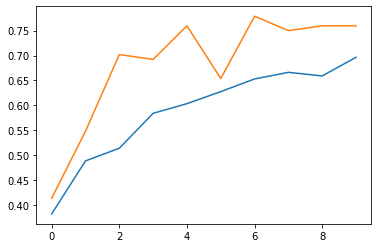

In [39]:
plt.plot(history_CNN.history['accuracy'])
plt.plot(history_CNN.history['val_accuracy'])

In [85]:
history_CNN_loss = history_CNN.history['loss']
history_CNN_accuracy = history_CNN.history['accuracy']



Transfer learning, using a base model different from the VGG16. Keeping the values of loss and accuracy in a history object.

In [50]:
base_model = tf.keras.applications.DenseNet201(input_shape=(125,125,3), pooling='avg',classes=10, include_top=False, weights='imagenet')

In [51]:
preprocess_input = tf.keras.applications.densenet.preprocess_input

In [52]:
base_model.trainable = False

In [79]:
base_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 125, 125, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 131, 131, 3)  0          ['input_10[0][0]']               
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 63, 63, 64)   9408        ['zero_padding2d_2[0][0]']       
                                                                                        

In [53]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [54]:
prediction_layer = tf.keras.layers.Dense(3)

In [55]:
inputs = tf.keras.Input(shape=(500, 500, 3))
x = DataAugmentation(inputs)
x = tf.keras.layers.experimental.preprocessing.Resizing(125,125)(inputs)
x = preprocess_input(x)
x = base_model(x)
outputs_t = prediction_layer(x)
model_t = tf.keras.Model(inputs, outputs_t)

In [56]:
model_t.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 500, 500, 3)]     0         
                                                                 
 resizing_4 (Resizing)       (None, 125, 125, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 125, 125, 3)      0         
 da)                                                             
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 125, 125, 3)      0         
 a)                                                              
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 125, 125, 3)      0         
 da)                                                             
                                                           

In [57]:
base_learning_rate = 0.0001
model_t.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [58]:
history_t = model_t.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
26/26 [==============================] - 35s 825ms/step - loss: 1.2107 - accuracy: 0.3301 - val_loss: 1.1523 - val_accuracy: 0.3654
Epoch 2/10
26/26 [==============================] - 17s 600ms/step - loss: 1.1411 - accuracy: 0.3277 - val_loss: 1.1165 - val_accuracy: 0.3269
Epoch 3/10
26/26 [==============================] - 17s 598ms/step - loss: 1.1099 - accuracy: 0.3422 - val_loss: 1.1081 - val_accuracy: 0.3365
Epoch 4/10
26/26 [==============================] - 17s 585ms/step - loss: 1.1043 - accuracy: 0.3374 - val_loss: 1.1084 - val_accuracy: 0.2981
Epoch 5/10
26/26 [==============================] - 17s 593ms/step - loss: 1.1035 - accuracy: 0.3301 - val_loss: 1.1097 - val_accuracy: 0.2596
Epoch 6/10
26/26 [==============================] - 17s 593ms/step - loss: 1.1034 - accuracy: 0.2950 - val_loss: 1.1085 - val_accuracy: 0.2885
Epoch 7/10
26/26 [==============================] - 17s 582ms/step - loss: 1.1032 - accuracy: 0.3047 - val_loss: 1.1084 - val_accuracy: 0.2596

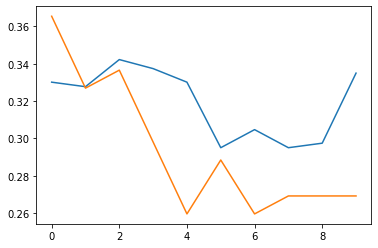

In [59]:
plt.plot(history_t.history['accuracy'])
plt.plot(history_t.history['val_accuracy'])

In [84]:
history_t_loss = history_t.history['loss']
history_t_accuracy = history_t.history['accuracy']



Fine-tuning, "freezing" a part of convolutional layers of base model. Keeping the values of loss and accuracy in a history object.

In [69]:
# base_model has 708 layers 
base_model.trainable = True
fine_tune_at = 300
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [70]:
model_t.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 500, 500, 3)]     0         
                                                                 
 resizing_4 (Resizing)       (None, 125, 125, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 125, 125, 3)      0         
 da)                                                             
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 125, 125, 3)      0         
 a)                                                              
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 125, 125, 3)      0         
 da)                                                             
                                                           

In [72]:
model_t.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [73]:
history_fine = model_t.fit(train_ds,
                         epochs=20,
                         initial_epoch=history_t.epoch[-1],
                         validation_data=val_ds)

Epoch 10/20
26/26 [==============================] - 46s 826ms/step - loss: 1.6357 - accuracy: 0.4075 - val_loss: 1.1051 - val_accuracy: 0.3173
Epoch 11/20
26/26 [==============================] - 18s 608ms/step - loss: 1.1423 - accuracy: 0.5308 - val_loss: 1.1061 - val_accuracy: 0.3173
Epoch 12/20
26/26 [==============================] - 18s 613ms/step - loss: 0.9459 - accuracy: 0.5985 - val_loss: 1.1343 - val_accuracy: 0.3269
Epoch 13/20
26/26 [==============================] - 18s 609ms/step - loss: 0.8346 - accuracy: 0.6409 - val_loss: 1.1992 - val_accuracy: 0.3269
Epoch 14/20
26/26 [==============================] - 18s 610ms/step - loss: 0.7278 - accuracy: 0.6844 - val_loss: 1.2151 - val_accuracy: 0.3269
Epoch 15/20
26/26 [==============================] - 18s 614ms/step - loss: 0.6882 - accuracy: 0.7001 - val_loss: 1.1734 - val_accuracy: 0.3558
Epoch 16/20
26/26 [==============================] - 18s 611ms/step - loss: 0.6576 - accuracy: 0.7376 - val_loss: 1.1317 - val_accuracy:

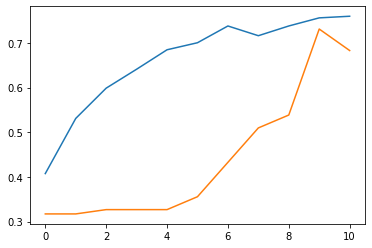

In [74]:
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])

In [83]:
history_fine_loss = history_fine.history['loss']
history_fine_accuracy = history_fine.history['accuracy']



Comparing (on plots) the accuraces and loss function values for models, both for the training and validation datasets. Presenting accuracies of all the models for the testing dataset.

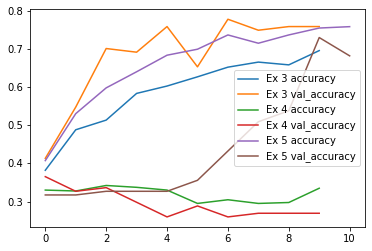

In [94]:
plt.plot(history_CNN.history['accuracy'])
plt.plot(history_CNN.history['val_accuracy'])
plt.plot(history_t.history['accuracy'])
plt.plot(history_t.history['val_accuracy'])
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.legend(['Ex 3 accuracy','Ex 3 val_accuracy', 'Ex 4 accuracy','Ex 4 val_accuracy','Ex 5 accuracy', 'Ex 5 val_accuracy'])

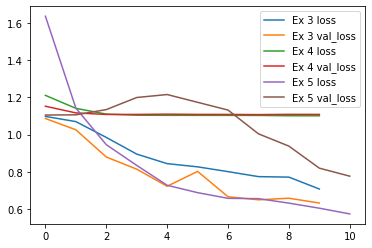

In [93]:
plt.plot(history_CNN.history['loss'])
plt.plot(history_CNN.history['val_loss'])
plt.plot(history_t.history['loss'])
plt.plot(history_t.history['val_loss'])
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.legend(['Ex 3 loss','Ex 3 val_loss', 'Ex 4 loss','Ex 4 val_loss','Ex 5 loss', 'Ex 5 val_loss'])

In [76]:
model_cnn.evaluate(test_ds)

4/4 [==============================] - 1s 123ms/step - loss: 0.6558 - accuracy: 0.7184


[0.6558259129524231, 0.7184466123580933]

In [77]:
model_t.evaluate(test_ds)

4/4 [==============================] - 2s 560ms/step - loss: 0.6826 - accuracy: 0.7087


[0.6825509667396545, 0.708737850189209]